# Passo 1. Setup do projeto

In [1]:
import os
import urllib

import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns 

import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
WINE_ROOT = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/'
WINE_URL = WINE_ROOT+'wine.data'

DATA_PATH = os.path.join('..', 'data', 'raw')
DATA_FILE = 'wine.csv'

WINE_DATA = os.path.join(DATA_PATH, DATA_FILE)

# Passo 2. Recuperação dos dados

In [3]:
def download_data(data_url, data_path, data_file):
    os.makedirs(data_path, exist_ok=True)
    local_path = os.path.join(data_path, data_file)
    urllib.request.urlretrieve(data_url, local_path)

download_data(WINE_URL, DATA_PATH, DATA_FILE)

In [4]:
names = ['class', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols','Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']
wine_data = pd.read_csv(WINE_DATA, header=None, names=names)
wine_data.head()

class  Alcohol  Malic acid   Ash  Alcalinity of ash  Magnesium  \
0      1    14.23        1.71  2.43               15.6        127   
1      1    13.20        1.78  2.14               11.2        100   
2      1    13.16        2.36  2.67               18.6        101   
3      1    14.37        1.95  2.50               16.8        113   
4      1    13.24        2.59  2.87               21.0        118   

   Total phenols  Flavanoids  Nonflavanoid phenols  Proanthocyanins  \
0           2.80        3.06                  0.28             2.29   
1           2.65        2.76                  0.26             1.28   
2           2.80        3.24                  0.30             2.81   
3           3.85        3.49                  0.24             2.18   
4           2.80        2.69                  0.39             1.82   

   Color intensity   Hue  OD280/OD315 of diluted wines  Proline  
0             5.64  1.04                          3.92     1065  
1             4.38  1.05                          3.40     1050  
2             5.68  1.03                          3.17     1185  
3             7.80  0.86                          3.45     1480  
4             4.32  1.04                          2.93      735

# Passo 3. Análise exploratória dos dados

## Verificação de dados nulos ou ausentes


In [5]:
wine_data.isnull().sum()

class                           0
Alcohol                         0
Malic acid                      0
Ash                             0
Alcalinity of ash               0
Magnesium                       0
Total phenols                   0
Flavanoids                      0
Nonflavanoid phenols            0
Proanthocyanins                 0
Color intensity                 0
Hue                             0
OD280/OD315 of diluted wines    0
Proline                         0
dtype: int64

In [6]:
wine_data[wine_data == 0].count()

class                           0
Alcohol                         0
Malic acid                      0
Ash                             0
Alcalinity of ash               0
Magnesium                       0
Total phenols                   0
Flavanoids                      0
Nonflavanoid phenols            0
Proanthocyanins                 0
Color intensity                 0
Hue                             0
OD280/OD315 of diluted wines    0
Proline                         0
dtype: int64

## Balanceamento dos dados

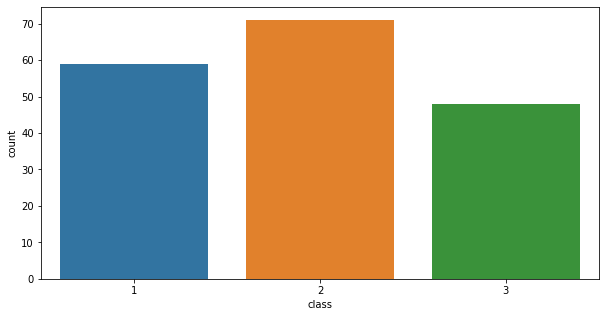

In [7]:
plt.figure(figsize=(10, 5))
_ = sns.countplot(x='class', data=wine_data)

## Correlação e distribuição dos dados


In [8]:
X = wine_data.drop(['class'], axis=1)
y = wine_data['class']

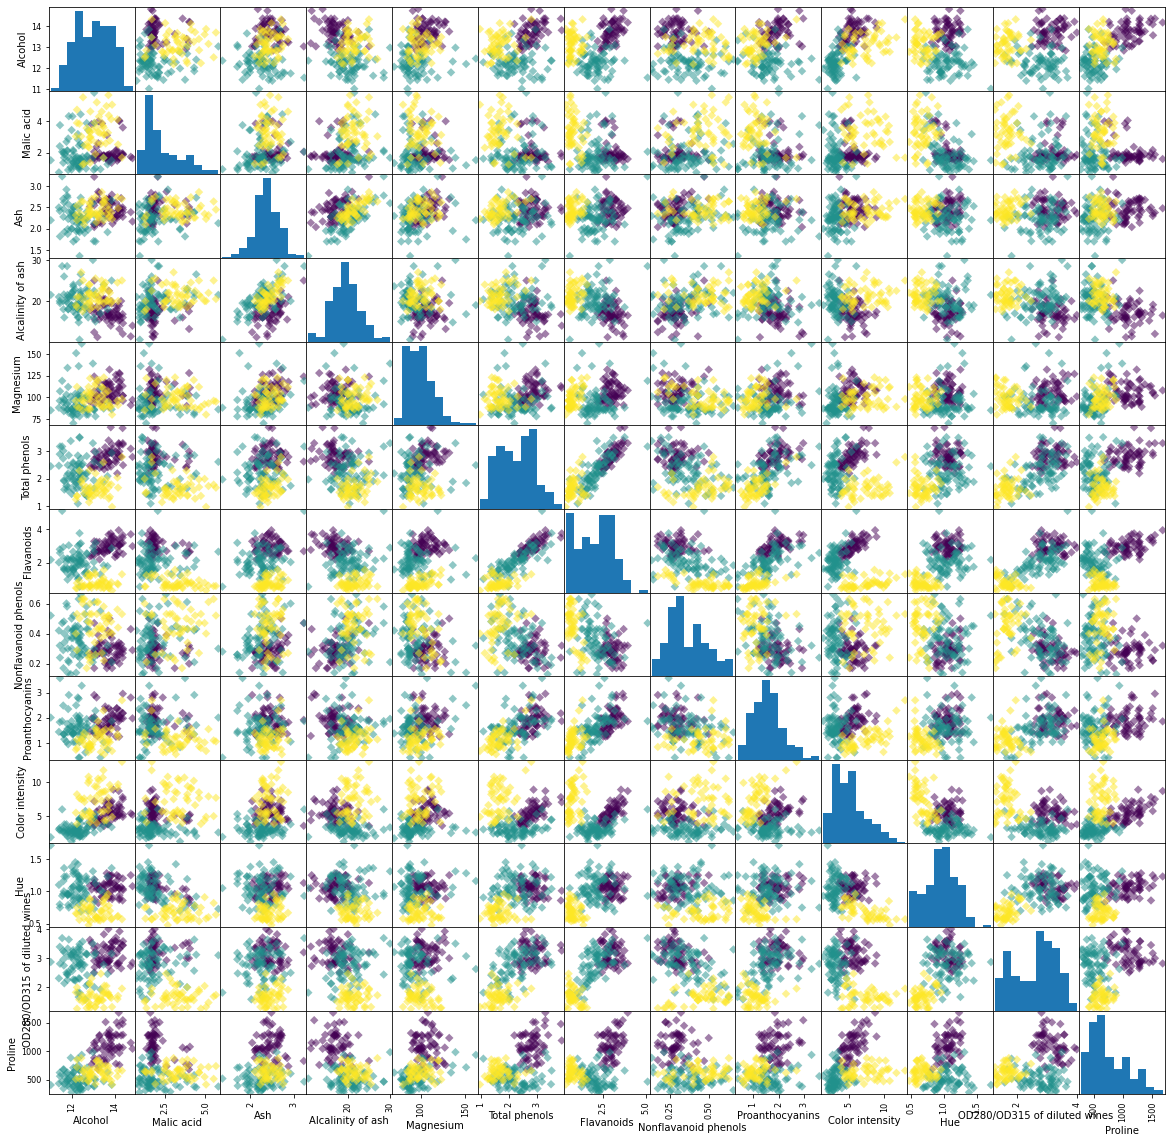

In [9]:
_ = pd.plotting.scatter_matrix(X, c=y, figsize=[20,20], marker='D')

# Passo 4. Avaliação dos classficadores

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.3, random_state=42)

In [11]:
#Normalização dos dados. Melhorou o desempenho do SVM e aumentou a acurácia em todos os classificadores.
scaling = MinMaxScaler(feature_range=(0,1)).fit(X_train)
X_train = scaling.transform(X_train)
X_test = scaling.transform(X_test)

In [12]:
def build_classifiers():
    classifiers = []
    classifiers.append(
                      ('knn',                              # nome do classificador
                        KNeighborsClassifier(),            # instancia do classificador
                        {'n_neighbors' : range(1, 33, 2)}  # hiperparametros
                      )
    )
    
    classifiers.append(
                      ('lr',                               # nome do classificador
                        LogisticRegression(max_iter=1000), # instancia do classificador
                        {'penalty' : ['l2'], 'C' : [100, 10, 1, 0.1, 0.01]}  # hiperparametros
                      )
    )
    
    classifiers.append(
                      ('svm',
                        SVC(),
                        {'kernel' : ['linear', 'rbf'], 
                         'C' : [2 ** (-5), 1, 2 ** 5, 2 ** 10],
                         'gamma' : [2 ** (-15), 2 ** (-10), 2 ** (-5), 1, 2 ** 5]
                        }
                      )
    )
    
    classifiers.append(
                      ('dt',
                        DecisionTreeClassifier(),
                        {'max_depth' : [2, 4, 6, 8, 10, 12]}
                      )  
    )
    
    classifiers.append(
                      ('rf',
                        RandomForestClassifier(),
                        {'n_estimators' : [10, 50, 100]}
                      ) 
    )
    classifiers.append(
                    ('gnb', 
                      GaussianNB(),
                      {'var_smoothing': [1E-8, 1E-9, 1E-10]}
                    )
    )
    return classifiers

In [13]:
classifiers = build_classifiers()
results = []
names = []

for name, model , parameters in classifiers:
    print('\n>> classifier name: {}'.format(name))
    gs = GridSearchCV(estimator=model, param_grid=parameters, refit=True, verbose=0)
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    cv = cross_val_score(gs, X_train, y_train, cv=kf, scoring='accuracy')
    print('Mean: {}, Standart Deviation: {}'.format(cv.mean(), cv.std()))
    gs.fit(X_train, y_train)
    print("Best parameters: {}".format(gs.best_params_))
    print("Best score: {}".format(gs.best_score_))
    results.append(cv)
    names.append(name)



>> classifier name: knn
Mean: 0.9673076923076922, Standart Deviation: 0.040078202647027154
Best parameters: {'n_neighbors': 5}
Best score: 0.9756666666666666

>> classifier name: lr
Mean: 0.9839743589743589, Standart Deviation: 0.032083317323697944
Best parameters: {'C': 100, 'penalty': 'l2'}
Best score: 0.9753333333333334

>> classifier name: svm
Mean: 0.9833333333333332, Standart Deviation: 0.03333333333333335
Best parameters: {'C': 32, 'gamma': 3.0517578125e-05, 'kernel': 'linear'}
Best score: 0.992

>> classifier name: dt
Mean: 0.8621794871794872, Standart Deviation: 0.09387250925984826
Best parameters: {'max_depth': 12}
Best score: 0.8856666666666666

>> classifier name: rf
Mean: 0.9589743589743589, Standart Deviation: 0.04106568558473583
Best parameters: {'n_estimators': 100}
Best score: 0.9836666666666666

>> classifier name: gnb
Mean: 0.9583333333333333, Standart Deviation: 0.05590169943749474
Best parameters: {'var_smoothing': 1e-08}
Best score: 0.9596666666666666


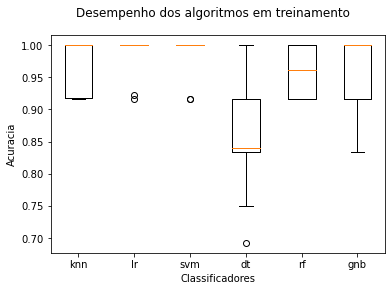

In [14]:
fig, ax = plt.subplots()
fig.suptitle('Desempenho dos algoritmos em treinamento')
plt.boxplot(results)
ax.set_xticklabels(names)
ax.set_xlabel('Classificadores')
ax.set_ylabel('Acuracia')
plt.show()

Entre os classificadores, o que teve o melhor desempenho foi o SVM com os hiperparâmetros {'C': 32, 'gamma': 3.0517578125e-05, 'kernel': 'linear'} 

In [15]:
clf = SVC(C = 32, gamma=3.0517578125e-05, kernel = 'linear')
clf.fit(X_train, y_train)
y_model = clf.predict(X_test)
score = accuracy_score(y_model, y_test)
report = classification_report(y_model, y_test)

print("Score: {}".format(score))
print(report)

Score: 0.9814814814814815
              precision    recall  f1-score   support

           1       1.00      0.95      0.97        19
           2       0.95      1.00      0.98        20
           3       1.00      1.00      1.00        15

    accuracy                           0.98        54
   macro avg       0.98      0.98      0.98        54
weighted avg       0.98      0.98      0.98        54



# Conclusão

O modelo de melhor desempenho foi o SVM, o qual apresentou um score de 98% com os dados de testes e um bom f1-score.